# One-sample feedforwardness testing: simulation

## Preliminaries

In [1]:
import datetime
import pprint
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspologic.plot import heatmap
from graspologic.simulations import sample_edges
from graspologic.utils import (
    augment_diagonal,
    binarize,
    multigraph_lcc_intersection,
    pass_to_ranks,
    remove_loops,
)
from pkg.data import load_adjacency, load_node_meta
from pkg.flow import rank_graph_match_flow
from pkg.io import savefig
from pkg.plot import set_theme
from pkg.utils import get_paired_inds, get_paired_subgraphs, set_warnings
from src.visualization import adjplot  # TODO fix graspologic version and replace here

set_warnings()

np.random.seed(8888)

t0 = time.time()


def stashfig(name, **kwargs):
    foldername = "feedforwardness_sims"
    savefig(name, foldername=foldername, **kwargs)


colors = sns.color_palette("Set1")
set_theme()

/Users/bpedigo/miniconda3/envs/maggot-revamp/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## A model of feedforwardness

### The upset model
This model is one of the simplest feedforward models we can think of. This model is
parameterized by two probabilities and a ranking/permutation of a set of nodes.

Let the feedforward probability be $p_{fwd}$, and let the feedback probability be
$p_{back}$. Assume we have a permutation of the nodes described by the vector of
integers $\phi \in \mathbb{R}^n$, where $n$ is the number of nodes. Each element of
$\phi$ is the node's "rank" in the network, which, along with the probabilities above,
determine its probability of connecting to other nodes in the network. Thus, each
element of $\phi$ is a unique integer $\in \{ 1 ... n - 1\}$.

If we sort $P$ according to $\phi$ (largest to smallest) then $P$ looks as follows:

$$
P_{ij} = \begin{cases}
p_{fwd} & i < j \\
p_{back} & i > j \\
0 & i = j \\
\end{cases}
$$

Thus, $P$ has all $p_{fwd}$ on the upper triangle, and all $p_{back}$ on the lower
triangle. Note that this can equivalently be parameterized as

$$
p = \frac{p_{fwd} + p_{back}}{2} \quad
\delta = \frac{p_{fwd} - p_{back}}{2}
$$

Under this parameterization, $\delta \in [0, 0.5]$ can be thought of as how
feedforward the network is - high values mean feedforward edges are far much more
likely, and thus the network structure respects the ranking $\phi$ more. $p$ then just
sets the overall density of the network.

<AxesSubplot:title={'center':'A (estimated permutation)\n$p_{upper} = $0.65'}>

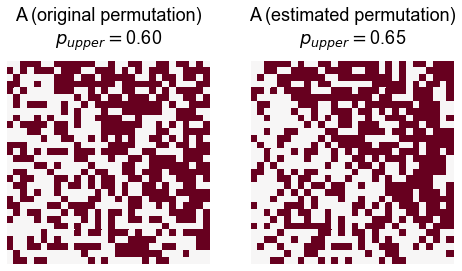

In [2]:


def calculate_p_upper(A):
    A = remove_loops(A)
    n = len(A)
    triu_inds = np.triu_indices(n, k=1)
    upper_triu_sum = A[triu_inds].sum()
    total_sum = A.sum()
    upper_triu_p = upper_triu_sum / total_sum
    return upper_triu_p


def construct_feedforward_P(n, p=0.5, delta=0):
    triu_inds = np.triu_indices(n, k=1)
    p_upper = p + delta
    p_lower = p - delta
    P = np.zeros((n, n))
    P[triu_inds] = p_upper
    P[triu_inds[::-1]] = p_lower
    return P


n = 30
p = 0.5

P = construct_feedforward_P(n, p=p, delta=0.1)

A = sample_edges(P, directed=True, loops=False)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

p_upper = calculate_p_upper(A)
title = "A (original permutation)\n"
title += r"$p_{upper} = $" + f"{p_upper:0.2f}"
heatmap(A, cbar=False, ax=axs[0], title=title)

perm_inds = rank_graph_match_flow(A)
p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])

title = "A (estimated permutation)\n"
title += r"$p_{upper} = $" + f"{p_upper:0.2f}"
heatmap(A[np.ix_(perm_inds, perm_inds)], cbar=False, ax=axs[1], title=title)

### A test for a notion of feedforwardness
We'll use the simple model above to motivate a one-sided test for feedforwardness as
follows:

$$
H_0: p_{upper} = p_{lower} = p
$$

$$
H_A: p_{upper} > p_{lower}
$$

### Simulate from the null

In [3]:
rows = []
n_null_samples = 1000
null = []
currtime = time.time()
for i in range(n_null_samples):
    P = construct_feedforward_P(n, p=p, delta=0)
    A = sample_edges(P, directed=True, loops=False)
    perm_inds = rank_graph_match_flow(A)
    p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])
    null.append(p_upper)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

36.673 seconds elapsed.


### Simulate from the alternative
Note that here I am calculating p-values using the null distribution from the above.
This assumes that the parameter $p$ is known, thus we only need to estimate $\delta$.
In real data we would have to use the plug in estimate of $\hat{p}$ which is the ER
global connection probability that we'd estimate from the data
(i.e. $\frac{M}{N (N - 1)}$).

In [4]:
deltas = np.linspace(0, 0.25, num=11)
n_samples = 200
null = np.array(null)
null = np.sort(null)
currtime = time.time()
for delta in deltas:
    P = construct_feedforward_P(n, p=p, delta=delta)
    for i in range(n_samples):
        row = {}
        A = sample_edges(P, directed=True, loops=False)
        sampled_p_upper = calculate_p_upper(A)
        row["sampled_p_upper"] = sampled_p_upper
        perm_inds = rank_graph_match_flow(A)
        p_upper = calculate_p_upper(A[np.ix_(perm_inds, perm_inds)])
        row["estimated_p_upper"] = p_upper
        row["estimated_p"] = np.sum(A) / (A.size - len(A))
        ind = np.searchsorted(null, p_upper)
        pvalue = 1 - ind / len(null)  # TODO make more exact but this is roughly right
        # for the 1-sided test
        row["pvalue"] = pvalue
        row["delta"] = delta
        row["str_delta"] = f"{delta:0.3f}"
        rows.append(row)
print(f"{time.time() - currtime:.3f} seconds elapsed.")

results = pd.DataFrame(rows)

79.423 seconds elapsed.


### Create a color map

In [5]:
str_deltas = np.unique(results["str_delta"])
colors = sns.color_palette("husl", len(str_deltas))
palette = dict(zip(str_deltas, colors))
for i, d in enumerate(str_deltas):
    palette[float(d)] = colors[i]

### Plot the p-values from varying effect sizes

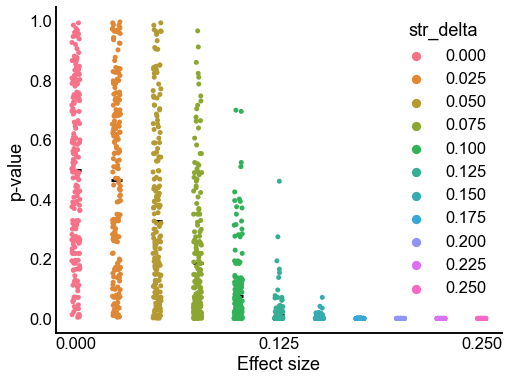

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    data=results,
    x="str_delta",
    y="pvalue",
    zorder=1,
    color="black",
    ci=None,
    join=False,
    markers="_",
    size=200,
)
sns.stripplot(
    data=results,
    x="str_delta",
    y="pvalue",
    hue="str_delta",
    palette=palette,
    zorder=2,
)
ax.set(xlabel="Effect size", ylabel="p-value")
ax.xaxis.set_major_locator(plt.FixedLocator([0, 5, 10]))

### Plot the distribution p-values under the null

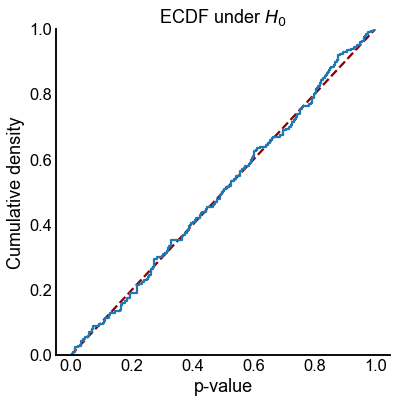

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.ecdfplot(data=results[results["str_delta"] == "0.000"], x="pvalue")
ax.set(xlabel="p-value", ylabel="Cumulative density", title=r"ECDF under $H_0$")
ax.plot([0, 1], [0, 1], color="darkred", linestyle="--", zorder=-1)

### Plot power for $\alpha = 0.05$

[Text(0, 0.5, 'Power'), Text(0.5, 0, 'Effect size')]

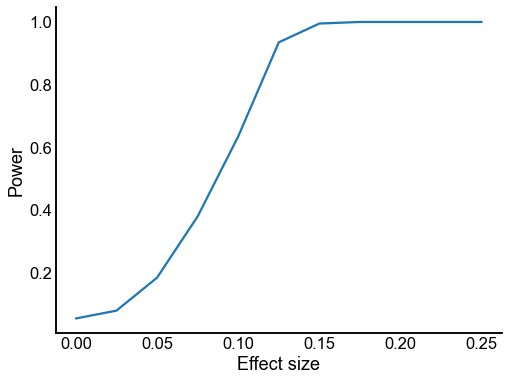

In [8]:
def calc_power_at(x, alpha=0.05):
    return (x < alpha).sum() / len(x)


grouped_results = results.groupby("str_delta")
power = grouped_results["pvalue"].agg(calc_power_at)
power.name = "power"
power = power.to_frame().reset_index()
power["delta"] = power["str_delta"].astype(float)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.lineplot(data=power, x="delta", y="power", ax=ax)
ax.set(ylabel="Power", xlabel="Effect size")

### Plot the "true" and estimated upper triangle probabilities

[Text(0.5, 0, '$p_{upper}$ under original permutation'),
 Text(0, 0.5, '$p_{upper}$ under estimated permutation')]

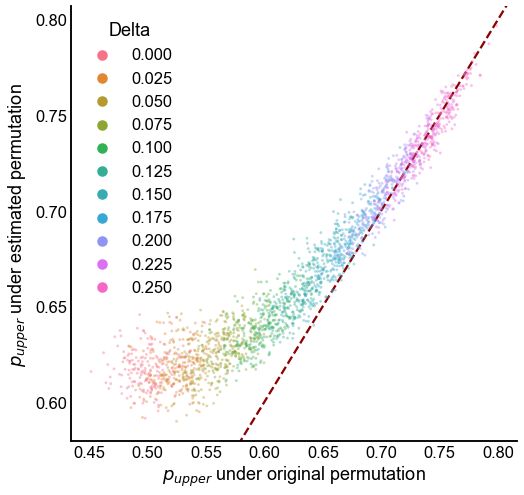

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=results,
    x="sampled_p_upper",
    y="estimated_p_upper",
    hue="str_delta",
    s=8,
    alpha=0.4,
    linewidth=0,
    ax=ax,
    zorder=10,
    palette=palette,
)
ax.get_legend().set_title("Delta")
plt.autoscale(False)
ax.plot([0, 1], [0, 1], color="darkred", linestyle="--", zorder=-1)
ax.set(
    xlabel=r"$p_{upper}$ under original permutation",
    ylabel=r"$p_{upper}$ under estimated permutation",
)

## End

In [10]:
elapsed = time.time() - t0
delta = datetime.timedelta(seconds=elapsed)
print("----")
print(f"Script took {delta}")
print(f"Completed at {datetime.datetime.now()}")
print("----")

----
Script took 0:01:59.286758
Completed at 2021-03-22 20:11:09.574441
----
